In [1]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
!ls /Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/

stayz_nsw_extract_2018-01-26.json.gz  stayz_nsw_extract_2018-03-10.json.gz
stayz_nsw_extract_2018-02-17.json.gz  stayz_nsw_extract_2018-03-11.json.gz
stayz_nsw_extract_2018-02-22.json.gz  stayz_nsw_extract_2018-03-12.json.zip
stayz_nsw_extract_2018-02-26.json.gz  stayz_nsw_extract_2018-03-13.json.zip
stayz_nsw_extract_2018-02-28.json.gz  stayz_nsw_extract_2018-03-14.json.zip
stayz_nsw_extract_2018-03-02.json.gz  stayz_nsw_extract_2018-03-15.json.zip
stayz_nsw_extract_2018-03-03.json.gz  stayz_nsw_extract_2018-03-16.json.zip
stayz_nsw_extract_2018-03-04.json.gz  stayz_nsw_extract_2018-03-17.json.zip
stayz_nsw_extract_2018-03-05.json.gz  stayz_nsw_extract_2018-03-18.json.zip
stayz_nsw_extract_2018-03-06.json.gz  stayz_nsw_extract_2018-03-19.json.zip
stayz_nsw_extract_2018-03-08.json.gz  stayz_nsw_extract_2018-03-20.json.zip
stayz_nsw_extract_2018-03-09.json.gz  stayz_nsw_extract_2018-03-21.json.zip
stayz_nsw_extract_2018-03-10.csv      stayz_nsw_extract_2018-03-22.json.zip
stayz_nsw_extr

In [18]:
#date_str = datetime.datetime.now().strftime("%Y-%m-%d")

date_str ='2018-03-22'

# Read the data file and display
nsw_data = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/stayz_nsw_extract_' + date_str + '.json.zip')

nsw_data = nsw_data.reset_index(drop=True)
nsw_data = nsw_data.set_index('property_id')

# If the initial price is zero, set to NaN so it doesnt affect the statistics
nsw_data.loc[nsw_data['init_price'] == 0,'init_price'] = np.nan

nsw_data.head()

bathrooms  bedrooms  beds  \
property_id                              
9082944              2         3     7   
9140176              2         4     9   
9197130              3         3     3   
9060297              2         2     2   
9132622              2         5     6   

                                              description_full  guests  \
property_id                                                              
9082944                   "The Best in Culburra " Kate Nov 17        8   
9140176      AWARDED AUSTRALIA'S TOP PET FRIENDLY RENTAL FO...       9   
9197130      Architecturally designed with bespoke interior...       6   
9060297                La Petite Maison is perfectly stunning        4   
9132622      This is a cosy 4-5 bedroom cottage for $200/ni...       9   

                                                       heading  init_price  \
property_id                                                                  
9082944      Escape@Culburra ABSOLUTE BEACH FRONT luxury be...       446.0   
9140176               BLUE ISLAND - Award winning holiday home       242.0   
9197130         140 Mitchell at Mollymook - Luxury Beach House       790.0   
9060297                 La Petite Maison Leura- Blue Mountains       269.0   
9132622                                  Millthorpe Cottage 18       204.0   

                   lat        lng property_type  reviews         scraped_date  \
property_id                                                                     
9082944     -34.933100  150.77500         House      174  2018-03-22 01:00:08   
9140176     -34.924686  150.76315         House       51  2018-03-22 01:00:08   
9197130     -35.324104  150.47970         House       22  2018-03-22 01:00:09   
9060297     -33.714140  150.32840       Cottage       87  2018-03-22 01:00:09   
9132622     -33.442738  149.18095         House       59  2018-03-22 01:00:09   

            syd_brg  syd_brg_deg  syd_dist_km  \
property_id                                     
9082944           S          199          111   
9140176           S          200          110   
9197130          SW          203          161   
9060297           W          291           84   
9132622           W          287          194   

                                                           url  
property_id                                                     
9082944      https://www.stayz.com.au//accommodation/nsw/so...  
9140176      https://www.stayz.com.au//accommodation/nsw/so...  
9197130      https://www.stayz.com.au//accommodation/nsw/so...  
9060297      https://www.stayz.com.au//accommodation/nsw/bl...  
9132622      https://www.stayz.com.au//accommodation/nsw/ex...

In [4]:
nsw_data.describe()

bathrooms      bedrooms          beds        guests     init_price  \
count  18157.000000  18157.000000  18157.000000  18157.000000   17915.000000   
mean       1.852013      2.961502      4.278460      6.661508     313.021490   
std        1.207840      1.610341      3.180739      3.860075    2349.784097   
min        0.000000      0.000000      0.000000      1.000000       1.000000   
25%        1.000000      2.000000      3.000000      4.000000     141.000000   
50%        2.000000      3.000000      4.000000      6.000000     208.000000   
75%        2.000000      4.000000      5.000000      8.000000     330.000000   
max       50.000000     50.000000    100.000000    120.000000  312197.000000   

                lat           lng       reviews   syd_brg_deg   syd_dist_km  
count  18157.000000  18157.000000  18157.000000  18157.000000  18157.000000  
mean     -33.180893    151.274946      5.675552    111.039985    226.119128  
std        2.533160      4.566482     12.327407    107.070214    329.218611  
min      -41.453060   -100.945830      0.000000      0.000000      0.000000  
25%      -34.795284    150.534000      0.000000     22.000000     81.000000  
50%      -33.605840    151.270000      1.000000     32.000000    163.000000  
75%      -32.340940    152.465270      5.000000    203.000000    341.000000  
max       41.970135    167.949000    193.000000    359.000000  15713.000000

In [5]:
# Filter for 4 or less guests
nsw_data_s1 = nsw_data.loc[nsw_data['guests'] <= 4]

# Filter for 4 or less bathrooms
nsw_data_s2 = nsw_data_s1.loc[nsw_data_s1['bathrooms'] <= 4 ]

# Fileter for 4 or less bedrooms
nsw_data_s3 = nsw_data_s2.loc[nsw_data_s2['beds'] <= 4 ]


nsw_data_s3.head()

bathrooms  bedrooms  beds  \
property_id                              
9060297              2         2     2   
9026665              1         2     3   
9060812              2         2     3   
9069072              2         2     2   
9208330              1         1     1   

                                              description_full  guests  \
property_id                                                              
9060297                La Petite Maison is perfectly stunning        4   
9026665      Modern spacious ground floor apartment set in ...       4   
9060812      Our 4 cottages are set in a glorious bushland ...       4   
9069072      Surrounded by national parkland, with its own ...       4   
9208330      MID WEEK SPECIAL RATE - Minimum two nights. Th...       2   

                                                       heading  init_price  \
property_id                                                                  
9060297                 La Petite Maison Leura- Blue Mountains       269.0   
9026665                     50 Metres to the Beach...Byron Bay       208.0   
9060812                           TOUCHDOWN COTTAGES JINDABYNE       128.0   
9069072      The Treehouse - Hawkesbury River. Tranquil wat...       260.0   
9208330                        Mill Paddock - Romantic Getaway       214.0   

                  lat        lng property_type  reviews         scraped_date  \
property_id                                                                    
9060297     -33.71414  150.32840       Cottage       87  2018-03-22 01:00:09   
9026665     -28.64100  153.61000     Apartment       15  2018-03-22 01:00:09   
9060812     -36.42840  148.60300       Cottage       45  2018-03-22 01:00:09   
9069072     -33.43125  151.05113         House       75  2018-03-22 01:00:10   
9208330     -33.45062  150.60938       Cottage       12  2018-03-22 01:00:10   

            syd_brg  syd_brg_deg  syd_dist_km  \
property_id                                     
9060297           W          291           84   
9026665           N           21          638   
9060812          SW          220          358   
9069072           N          349           63   
9208330          NW          318           79   

                                                           url  
property_id                                                     
9060297      https://www.stayz.com.au//accommodation/nsw/bl...  
9026665      https://www.stayz.com.au//accommodation/nsw/no...  
9060812      https://www.stayz.com.au//accommodation/nsw/sn...  
9069072      https://www.stayz.com.au//accommodation/nsw/sy...  
9208330      https://www.stayz.com.au//accommodation/nsw/bl...

In [6]:
# Testing - look in detail at any outliers

t1 = nsw_data_s3.loc[nsw_data_s3['init_price'] == 2200]
t1.head()

bathrooms  bedrooms  beds  \
property_id                              
176951               2         3     3   

                                              description_full  guests  \
property_id                                                              
176951       Contemporary Hotels presents, The Coogee. A th...       4   

                heading  init_price        lat        lng property_type  \
property_id                                                               
176951       THE COOGEE      2200.0 -33.923473  151.24829         House   

             reviews         scraped_date syd_brg  syd_brg_deg  syd_dist_km  \
property_id                                                                   
176951             0  2018-03-22 01:08:36      NE           40            9   

                                                           url  
property_id                                                     
176951       https://www.stayz.com.au//accommodation/nsw/sy...

In [7]:
nsw_data_s3.describe()


bathrooms     bedrooms         beds       guests   init_price  \
count  4852.000000  4852.000000  4852.000000  4852.000000  4766.000000   
mean      1.188788     1.582028     2.050289     3.329555   185.825220   
std       0.416885     0.544145     0.874491     0.905564   108.660453   
min       0.000000     0.000000     0.000000     1.000000    14.000000   
25%       1.000000     1.000000     1.000000     2.000000   122.000000   
50%       1.000000     2.000000     2.000000     4.000000   168.000000   
75%       1.000000     2.000000     3.000000     4.000000   224.000000   
max       4.000000     5.000000     4.000000     4.000000  2200.000000   

               lat          lng      reviews  syd_brg_deg   syd_dist_km  
count  4852.000000  4852.000000  4852.000000  4852.000000   4852.000000  
mean    -33.032877   151.088440     5.588829   104.562242    229.448269  
std       3.067691     7.695531    11.854341   111.267231    520.299258  
min     -41.293920   -84.997270     0.000000     0.000000      0.000000  
25%     -34.278292   150.638745     0.000000    21.000000     39.000000  
50%     -33.722362   151.235840     1.000000    30.000000    135.000000  
75%     -32.180789   152.203390     5.000000   203.000000    348.000000  
max      39.079407   153.635880   149.000000   359.000000  15713.000000

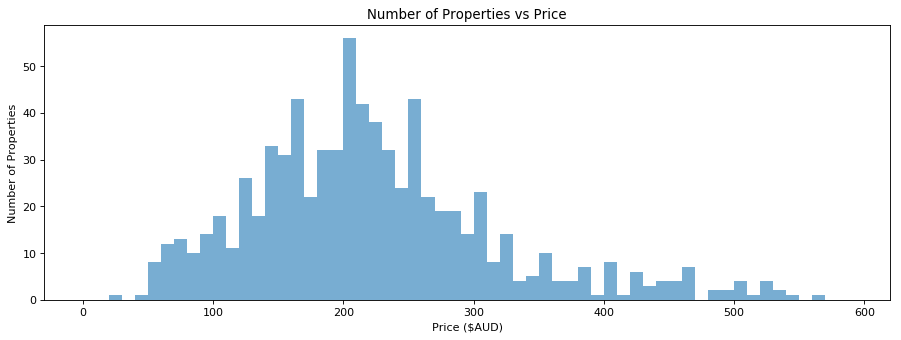

In [8]:
# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=600, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')



# Filter to only 2 bedroom units:
tran_small_price1 = nsw_data_s3.loc[nsw_data_s3['bedrooms'] == 2]

# Filter where distance to Sydney between 100-150km
tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_dist_km'] >= 100) & (tran_small_price1['syd_dist_km'] <= 150)]

tran_small_price_local = tran_small_price1.loc[(tran_small_price1['syd_brg'] == 'N')]


x = tran_small_price_local['init_price']

# Remove the rows where price is empty (NaN)
x = x.dropna()

ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

In [9]:
tran_small_price_local.describe()

bathrooms  bedrooms        beds      guests   init_price         lat  \
count  795.000000     795.0  795.000000  795.000000   778.000000  795.000000   
mean     1.421384       2.0    2.489308    3.924528   232.047558  -31.862264   
std      0.533319       0.0    0.594538    0.328096   127.479240    2.350784   
min      1.000000       2.0    0.000000    2.000000    23.000000  -33.908756   
25%      1.000000       2.0    2.000000    4.000000   158.000000  -33.826380   
50%      1.000000       2.0    2.000000    4.000000   213.500000  -33.437096   
75%      2.000000       2.0    3.000000    4.000000   270.750000  -28.788037   
max      3.000000       2.0    4.000000    4.000000  1375.000000  -27.484535   

              lng     reviews  syd_brg_deg  syd_dist_km  
count  795.000000  795.000000   795.000000   795.000000  
mean   152.036990    4.748428    42.763522   250.784906  
std      1.066095   11.518340    91.488018   279.514135  
min    150.885570    0.000000     0.000000     9.000000  
25%    151.220645    0.000000    13.000000    18.000000  
50%    151.334930    0.000000    19.000000    65.000000  
75%    153.510265    4.000000    21.000000   621.500000  
max    153.635440  126.000000   359.000000   744.000000

Text(0,0.5,'Count')

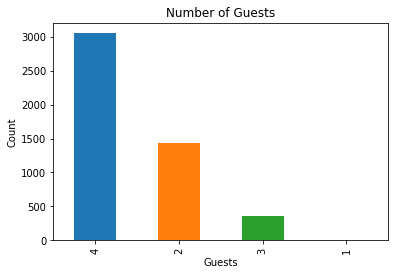

In [10]:
nsw_data_s3['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [11]:
nsw_data_s3['guests'].groupby(nsw_data_s3['guests']).count()

guests
1       4
2    1441
3     359
4    3048
Name: guests, dtype: int64

In [12]:
train_display = pd.DataFrame({
    #'Nbr Reviews': train_small['reviews'],
    'Price': nsw_data_s3['init_price'],
    'Type': nsw_data_s3['property_type'],
    'Bathrooms' : nsw_data_s3['bathrooms'],
    'Beds' : nsw_data_s3['beds']
})

#train_display.groupby('Type').hist()

Geocoded Data

In [13]:
# Read the data file and display
geodata = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_geocoded/stayz_geocoded_2018-03-08.json')

geodata = geodata.reset_index(drop=True)
geodata = geodata.set_index('property_id')

geodata.head()


council  \
property_id                   
9080772         Snowy River   
9117434         Great Lakes   
9069770          Shoalhaven   
9071475      Blue Mountains   
9006125         Snowy River   

                                             formatted_address  postcode  \
property_id                                                                
9080772          17 Ingebyra St, Jindabyne NSW 2627, Australia      2627   
9117434              458 Coomba Rd, Whoota NSW 2428, Australia      2428   
9069770      42 Penguins Head Rd, Culburra Beach NSW 2540, ...      2540   
9071475             9 Cross St, Blackheath NSW 2785, Australia      2785   
9006125      Riverside Cabins, 23 Diggings Terrace, Koscius...      2625   

                      st_name st_nbr state                    suburb  
property_id                                                           
9080772           Ingebyra St     17   NSW                 Jindabyne  
9117434             Coomba Rd    458   NSW                    Whoota  
9069770      Penguins Head Rd     42   NSW            Culburra Beach  
9071475              Cross St      9   NSW                Blackheath  
9006125      Diggings Terrace     23   NSW  Kosciuszko National Park

In [14]:
# Merge the nsw_extract with the geocoded data:
full_dataset = nsw_data.merge(geodata, how='inner', left_index=True, right_index=True)

full_dataset.head()

bathrooms  bedrooms  beds  \
property_id                              
9082944              2         3     7   
9024318              3         7    11   
9167523              2         4     6   
9151070              2         4     5   
9071475              1         2     5   

                                              description_full  guests  \
property_id                                                              
9082944                   "The Best in Culburra " Kate Nov 17        8   
9024318      Welcome to Orion's Lookout: Luxury accom in Je...      16   
9167523      BEAUTIFULLY DECORATED AND NEWLY RENOVATED HOME...       9   
9151070      Hank's at Mollymook comes equipped with everyt...       8   
9071475      Nestled high in a canopy of gum trees with stu...       5   

                                                       heading  init_price  \
property_id                                                                  
9082944      Escape@Culburra ABSOLUTE BEACH FRONT luxury be...       446.0   
9024318                             Orion's Lookout Jervis Bay       727.0   
9167523                               Callala Beach Pool House       342.0   
9151070                  Hank's at Mollymook - family friendly       249.0   
9071475                                 Braeside Cabin Retreat       160.0   

                   lat        lng property_type       ...        syd_brg_deg  \
property_id                                           ...                      
9082944     -34.933100  150.77500         House       ...                199   
9024318     -35.071800  150.68400         House       ...                200   
9167523     -35.013344  150.68716         House       ...                201   
9151070     -35.340458  150.46426         House       ...                203   
9071475     -33.640610  150.29774         Cabin       ...                295   

            syd_dist_km                                                url  \
property_id                                                                  
9082944             111  https://www.stayz.com.au//accommodation/nsw/so...   
9024318             128  https://www.stayz.com.au//accommodation/nsw/so...   
9167523             122  https://www.stayz.com.au//accommodation/nsw/so...   
9151070             163  https://www.stayz.com.au//accommodation/nsw/so...   
9071475              90  https://www.stayz.com.au//accommodation/nsw/bl...   

                    council  \
property_id                   
9082944          Shoalhaven   
9024318          Shoalhaven   
9167523          Shoalhaven   
9151070          Shoalhaven   
9071475      Blue Mountains   

                                             formatted_address postcode  \
property_id                                                               
9082944      180-182 Penguins Head Rd, Culburra Beach NSW 2...     2540   
9024318         3-5 Minerva Ave, Vincentia NSW 2540, Australia     2540   
9167523      13 Queen Mary St, Callala Beach NSW 2540, Aust...     2540   
9151070             30 Ilett St, Mollymook NSW 2539, Australia     2539   
9071475             9 Cross St, Blackheath NSW 2785, Australia     2785   

                      st_name   st_nbr  state          suburb  
property_id                                                    
9082944      Penguins Head Rd  180-182    NSW  Culburra Beach  
9024318           Minerva Ave      3-5    NSW       Vincentia  
9167523         Queen Mary St       13    NSW   Callala Beach  
9151070              Ilett St       30    NSW       Mollymook  
9071475              Cross St        9    NSW      Blackheath  

[5 rows x 23 columns]

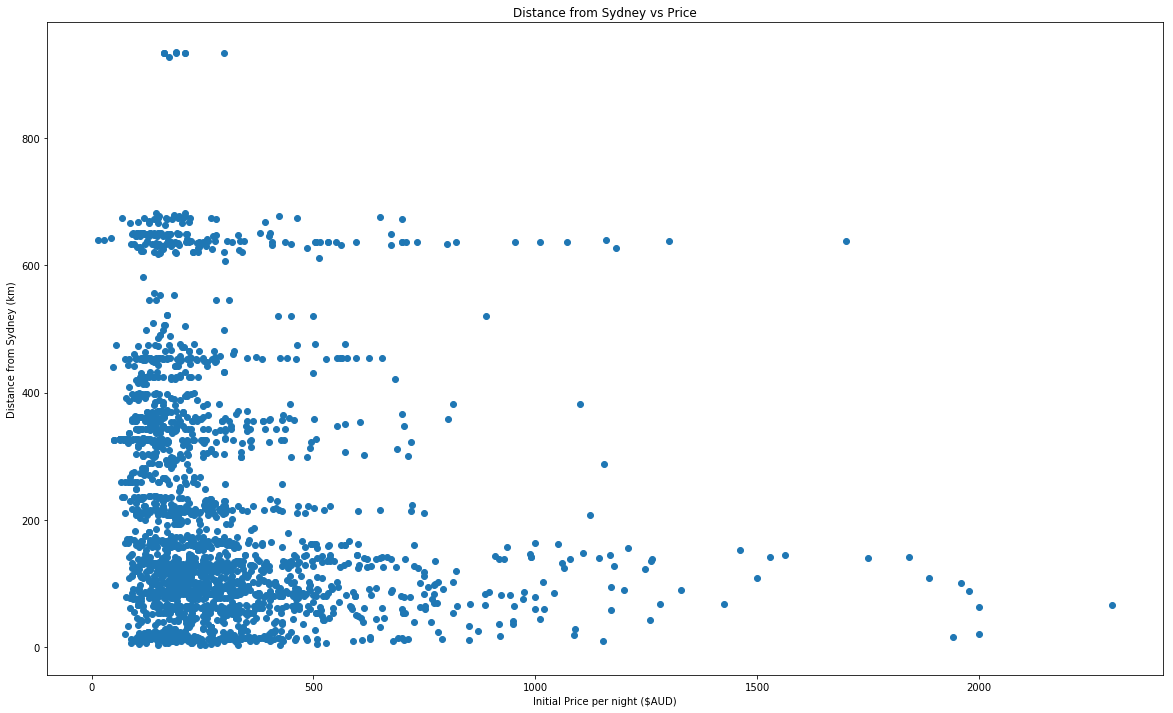

In [15]:
# Now draw a graph of Initial Price vs Distance from Sydney
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))

plt.title('Distance from Sydney vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(full_dataset['init_price'],full_dataset['syd_dist_km'])

plt.show()